In [1]:
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets

In [2]:
train_dataset = datasets.FashionMNIST(root="./datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="./datasets", download=True, train=False)

In [3]:
classes = train_dataset.classes

In [4]:
class_to_idx = train_dataset.class_to_idx

In [5]:
def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)

In [6]:
subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"Training Data Size : {len(subset_train_dataset)}")
print(f"Testing Data Size : {len(subset_test_dataset)}")
print(train_dataset[0])

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Training Data Size : 10000
Testing Data Size : 1000
(<PIL.Image.Image image mode=L size=28x28 at 0x712E2A921390>, 9)


In [7]:
import torch
from torchvision import transforms
from transformers import AutoImageProcessor


image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

In [9]:
print(f"size : {image_processor.size}")
print(f"mean : {image_processor.image_mean}")
print(f"std : {image_processor.image_std}")

size : {'height': 224, 'width': 224}
mean : [0.5, 0.5, 0.5]
std : [0.5, 0.5, 0.5]


In [10]:
from torch.utils.data import DataLoader

In [11]:
def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

In [12]:
batch = next(iter(train_dataloader))
for key, value in batch.items():
    print(f"{key} : {value.shape}")

pixel_values : torch.Size([32, 3, 224, 224])
labels : torch.Size([32])


In [13]:
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
    num_labels=len(classes),
    id2label={idx: label for label, idx in class_to_idx.items()},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)

print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [14]:
print(model.vit.embeddings)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)


In [15]:
batch = next(iter(train_dataloader))
print("image shape :", batch["pixel_values"].shape)
print("patch embeddings shape :", model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape)
print("[CLS] + patch embeddings shape :",    model.vit.embeddings(batch["pixel_values"]).shape)

image shape : torch.Size([32, 3, 224, 224])
patch embeddings shape : torch.Size([32, 196, 768])
[CLS] + patch embeddings shape : torch.Size([32, 197, 768])


In [16]:
( 224 - 16 ) / 16 + 1

14.0

In [17]:
14 * 14

196

In [18]:
from transformers import TrainingArguments
args = TrainingArguments(
    output_dir="./models/ViT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import evaluate
import numpy as np


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

In [24]:
from transformers import TrainingArguments, Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.442200,0.427590,0.917845
2,0.326500,0.371608,0.916324
3,0.287700,0.336950,0.923332


TrainOutput(global_step=1875, training_loss=0.3913509724934896, metrics={'train_runtime': 387.1997, 'train_samples_per_second': 77.479, 'train_steps_per_second': 4.842, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.3913509724934896, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.606022  , -0.47162354, -0.3969107 , ..., -0.60155284,
        -0.34007055, -0.54250467],
       [ 2.2506075 , -0.56719625, -0.35005826, ..., -0.68656945,
        -0.49515927, -0.74570465],
       [ 3.531372  , -0.45233014, -0.39398593, ..., -0.56135267,
        -0.31323707, -0.58892435],
       ...,
       [-0.8134304 , -0.70085776, -0.52300537, ...,  0.37502372,
        -0.3590688 ,  3.379669  ],
       [-0.5640193 , -0.5832975 , -0.452453  , ..., -0.19807787,
        -0.3930674 ,  3.6772575 ],
       [-0.61062765, -0.49275345, -0.43583134, ..., -0.34887424,
        -0.39203802,  3.6682062 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

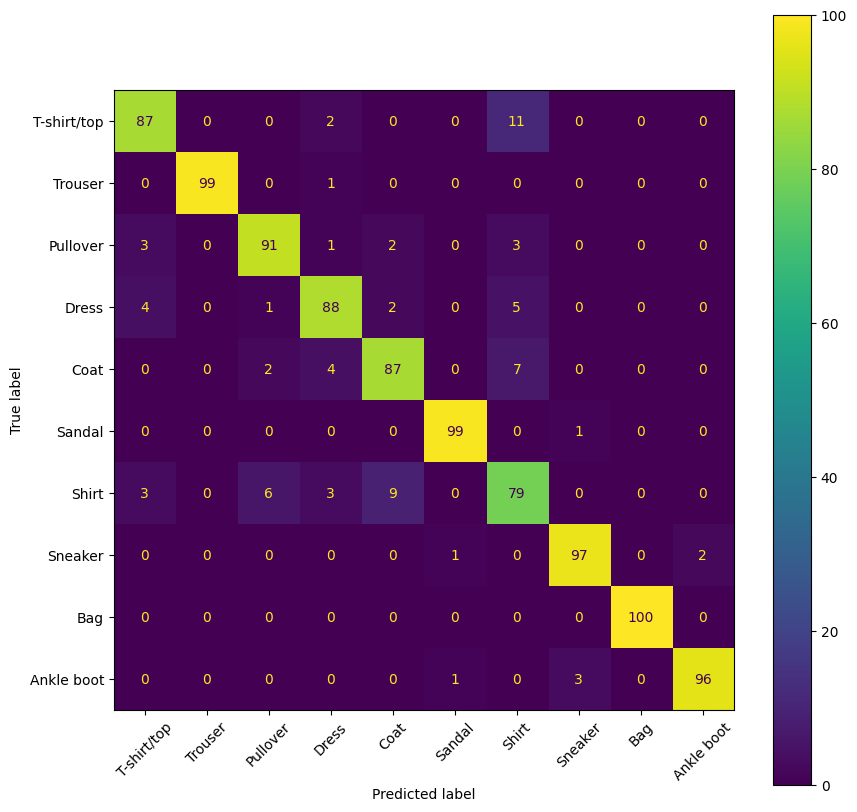

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

In [32]:
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [33]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

In [34]:
args = TrainingArguments(
    output_dir="./models/Swin-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
def model_init(classes, class_to_idx):
    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model

In [37]:
from transformers import SwinForImageClassification

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
trainer.train()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.376400,0.340098,0.865997
2,0.281300,0.280952,0.905906
3,0.248800,0.243020,0.921017


TrainOutput(global_step=1875, training_loss=0.3861856262207031, metrics={'train_runtime': 258.757, 'train_samples_per_second': 115.939, 'train_steps_per_second': 7.246, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.3861856262207031, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 8.05751   , -2.9550233 , -0.44811976, ..., -2.4817998 ,
         0.5092383 , -1.0895138 ],
       [ 4.647196  , -0.5833498 ,  1.1478868 , ..., -1.6684353 ,
         0.45173496, -1.7838258 ],
       [ 7.307342  , -3.0626314 , -0.18913925, ..., -2.4108386 ,
        -0.55006635, -1.3438106 ],
       ...,
       [-0.95572436, -1.8061016 , -0.89930475, ...,  1.1914138 ,
         0.6901976 ,  4.0916653 ],
       [-1.6231004 , -1.7396859 , -2.3867342 , ...,  1.7965753 ,
        -2.9927642 ,  9.145187  ],
       [-0.44646344, -0.82145107, -2.6193957 , ...,  0.38830224,
        -2.833555  ,  9.917731  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

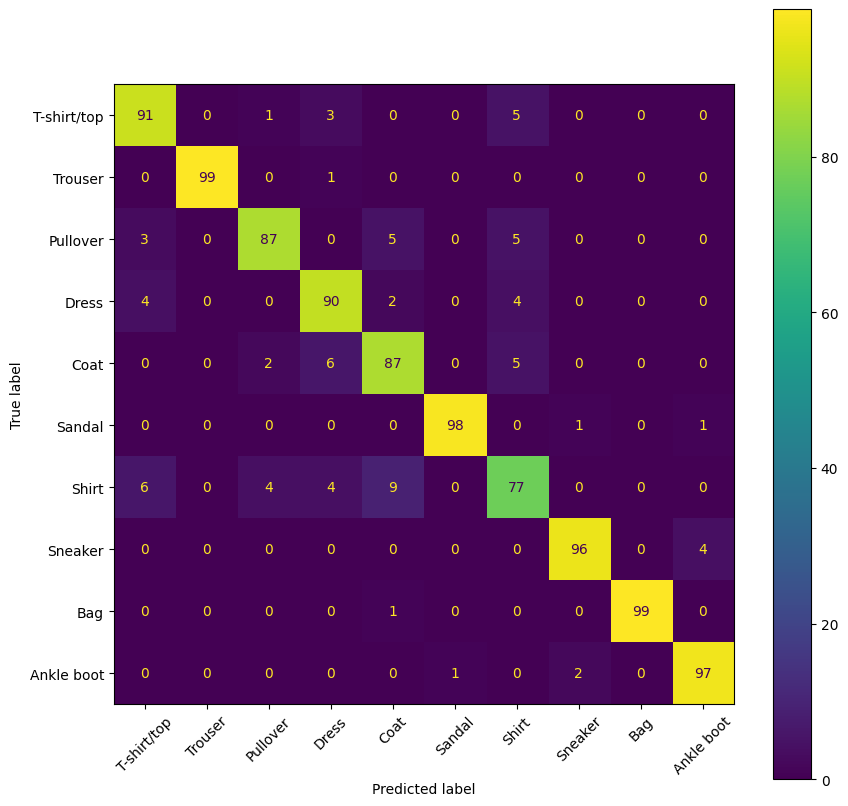

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

In [40]:
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [41]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

In [42]:
args = TrainingArguments(
    output_dir="./models/CvT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [44]:
from transformers import CvtForImageClassification
def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


In [45]:
trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,F1
1,0.822400,0.328224,0.892042
2,0.692400,0.275774,0.919144
3,0.673400,0.257146,0.929352


TrainOutput(global_step=1875, training_loss=0.7988302775065104, metrics={'train_runtime': 402.3393, 'train_samples_per_second': 74.564, 'train_steps_per_second': 4.66, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7988302775065104, 'epoch': 3.0})